In [2]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
#sns.set_style("whitegrid")

In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

In [4]:
import numpy as np
import pandas as pd
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

In [5]:
from chart_studio.plotly import iplot
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='pearl')

In [6]:
import yfinance as yf
df = yf.download("^GSPC", start="2010-01-05", end="2020-01-06",
                   group_by="ticker")

[*********************100%***********************]  1 of 1 completed


In [7]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020   
2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015  1137.140015   
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941   
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980   
2010-01-11  1145.959961  1149.739990  1142.020020  1146.979980  1146.979980   
...                 ...          ...          ...          ...          ...   
2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039  3221.290039   
2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029  3230.780029   
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   

                Volume  
Date                    
2010-01-05  2491020000  
2010-01-06  4972660000  
2010-01-07  5270680000  
2010-01-08  4389590000  
2010-01-11  4255780000  
...                ...  
2019-12-30  3013290000  
2019-12-31  2893810000  
2020-01-02  3458250000  
2020-01-03  3461290000  
2020-01-06  3674070000  

[2518 rows x 6 columns]

In [8]:
sentiment = pd.read_csv('sentiment.csv',index_col = 0)

In [9]:
sentiment.Date = pd.to_datetime(sentiment.Date)

In [10]:
df = pd.merge(df,sentiment, on = 'Date')

In [11]:
p = df['Open'].rolling(window = 1).mean()
df['ma1'] = p.diff()# 1 day window open price 
df['ma2'] = df['ma1'].diff() # moving average 
df['ma3'] = df['ma2'].diff()  #moving average
df['pricehighlowpercent'] = (df['High'] - df['Adj Close'])/df['Adj Close']*100 
df['pricechangepercent'] = (df['Adj Close'] - df['Open'])/df['Open']*100
df['vol_increment'] = df.Volume.diff()/df.Volume # current day volume increment
df['Open1'] = df.Open.shift(1)#current day open 
df['Open_increment'] = df.Open - df.Open.shift(1) #


In [12]:
df.drop('Articles', axis =1, inplace = True)

KeyError: "['Articles'] not found in axis"

In [13]:
df.index = df.Date

# Relative Strength Index

In [14]:
#df.reset_index(inplace = True)

In [15]:
def relative_strength_idx(df, n=14):
    close = df['Adj Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

# Plotting Close price and exponential moving average 

In [16]:
from plotly.subplots import make_subplots


In [17]:
EMA_12 = pd.Series(df['Adj Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Adj Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['Adj Close'], name='Adj Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

## optional-  SEE CHANGE PERCENT per day

In [18]:
def grouping(series):
    if series < 0:
        return "decrease"
    if series > 0:
        return "increase"

In [19]:
df['label'] = df['pricechangepercent'].apply(grouping)

In [20]:
#df.reset_index(inplace=True)

ValueError: cannot insert Date, already exists

In [21]:
df[['pricechangepercent']].iplot(kind = 'hist', title = 'Daily Price Change percentage')

In [30]:
np.median(abs(df.pricechangepercent))

0.3818190704934247

In [22]:
df.label.iplot(kind = 'hist')

In [627]:
#when the MACD falls below the signal line, it is a bearish signal which indicates that it may be time to sell. 
#Conversely, when the MACD rises above the signal line, the indicator gives a bullish signal, which suggests that the price of the asset is likely to experience upward momentum. Some traders wait for a confirmed cross above the signal line before entering a position to reduce th


## Model1 :  LINEAR REGRESSION 

In [22]:
df.index = df.Date
df.drop('Date',axis =1, inplace = True)

In [116]:
df.dropna(inplace = True)

In [121]:
df.drop('Close', axis =1, inplace = True)

In [126]:
df.drop('High',axis = 1, inplace = True)

In [128]:
df.drop('Low', axis =1, inplace = True)

In [132]:
#split into train and validation
train = df[:1980]
valid = df[1980:]
x_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
x_valid = valid.drop('Adj Close', axis=1)
y_valid = valid['Adj Close']
#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [133]:
preds = model.predict(x_valid)

In [134]:
model.score(x_train,y_train)

0.999941278958541

In [135]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

9.722260498151499

In [136]:
preds = pd.DataFrame(model.predict(x_valid), index = valid.index)

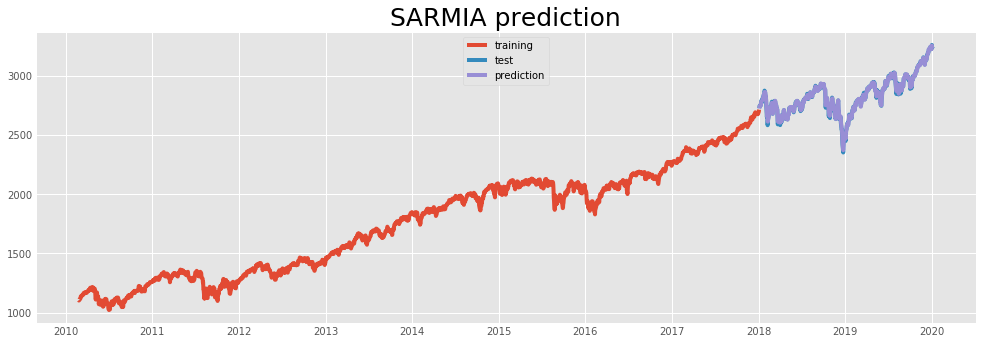

In [137]:
plt.figure(figsize = (15,5))
plt.plot(y_train, label = 'training')
plt.plot(y_valid, label= 'test')
plt.plot(preds, label = 'prediction')
plt.legend(loc = 'upper center')
plt.title('SARMIA prediction', size = 25)
plt.show()

## MODEL2: KNN

In [37]:
df

Date         Open         High          Low    Adj Close  \
0    2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015   
1    2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941   
2    2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980   
3    2010-01-11  1145.959961  1149.739990  1142.020020  1146.979980   
4    2010-01-12  1143.810059  1143.810059  1131.770020  1136.219971   
...         ...          ...          ...          ...          ...   
2510 2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039   
2511 2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029   
2512 2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098   
2513 2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098   
2514 2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029   

          Volume  polarityaverage  subjectivityavg        ma1        ma2  \
0     4972660000         0.004559         0.162312        NaN        NaN   
1     5270680000         0.003354         0.118907   0.560059        NaN   
2     4389590000         0.005087         0.141465   4.250000   3.689941   
3     4255780000         0.003285         0.081316   5.439941   1.189941   
4     4716160000         0.024642         0.121703  -2.149902  -7.589844   
...          ...              ...              ...        ...        ...   
2510  3013290000         0.031097         0.136687  -7.139893 -27.169922   
2511  2893810000         0.051078         0.187795 -24.910156 -17.770264   
2512  3458250000         0.035426         0.148915  29.489990  54.400146   
2513  3461290000         0.018826         0.172826 -18.309814 -47.799805   
2514  3674070000         0.073101         0.209759  -8.810059   9.499756   

             ma3  pricehighlowpercent  pricechangepercent  vol_increment  \
0            NaN             0.180270            0.125917            NaN   
1            NaN             0.067446            0.476992       0.056543   
2            NaN             0.035811            0.391046      -0.200723   
3      -2.500000             0.240633            0.089010      -0.031442   
4      -8.779785             0.668012           -0.663579       0.097618   
...          ...                  ...                 ...            ...   
2510  -45.449951             0.609380           -0.580232       0.194014   
2511    9.399658             0.029093            0.485201      -0.041288   
2512   72.170410             0.008895            0.406210       0.163215   
2513 -102.199951             0.349315            0.263145       0.000878   
2514   57.299561             0.017252            0.892915       0.057914   

            Open1  Open_increment  
0             NaN             NaN  
1     1135.709961        0.560059  
2     1136.270020        4.250000  
3     1140.520020        5.439941  
4     1145.959961       -2.149902  
...           ...             ...  
2510  3247.229980       -7.139893  
2511  3240.090088      -24.910156  
2512  3215.179932       29.489990  
2513  3244.669922      -18.309814  
2514  3226.360107       -8.810059  

[2515 rows x 16 columns]

In [69]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
#split into train and validation
train = df[:1980]
valid = df[1980:]
x_train = train.drop('Adj Close', axis=1)
y_train = train['Adj Close']
x_valid = valid.drop('Adj Close', axis=1)
y_valid = valid['Adj Close']
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
#fit the model and make predictions
model.fit(x_train,y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [70]:
preds = model.predict(x_valid)
preds = pd.DataFrame(model.predict(x_valid_scaled), index = valid.index)

Text(0.5, 1.0, 'KNN')

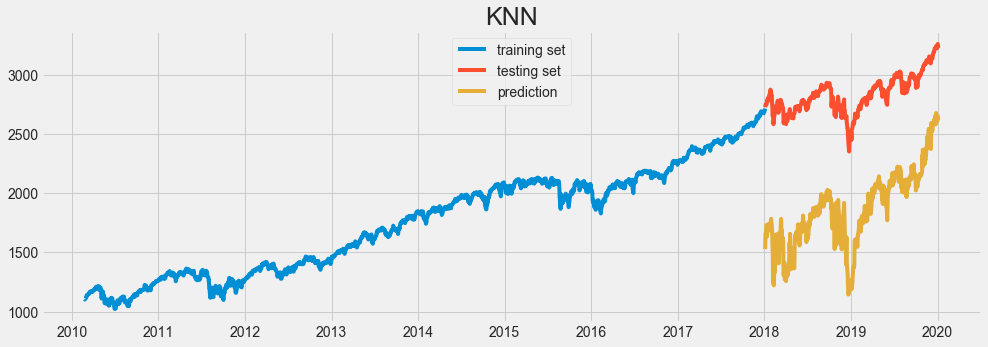

In [72]:
plt.figure(figsize = (15,5))
plt.plot(train['Adj Close'],label = 'training set')
plt.plot(valid[['Adj Close']], label = 'testing set')
plt.plot(preds, label = 'prediction')
plt.legend(loc = 'upper center')
plt.title('KNN', size = 25)

In [560]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

1036.817630621201

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
rfc = RandomForestRegressor()
#fit the model and make predictions
rfc.fit(x_train,y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [75]:
preds = rfc.predict(x_valid)
preds = pd.DataFrame(model.predict(x_valid_scaled), index = valid.index)

Text(0.5, 1.0, 'RandomForestRegressor')

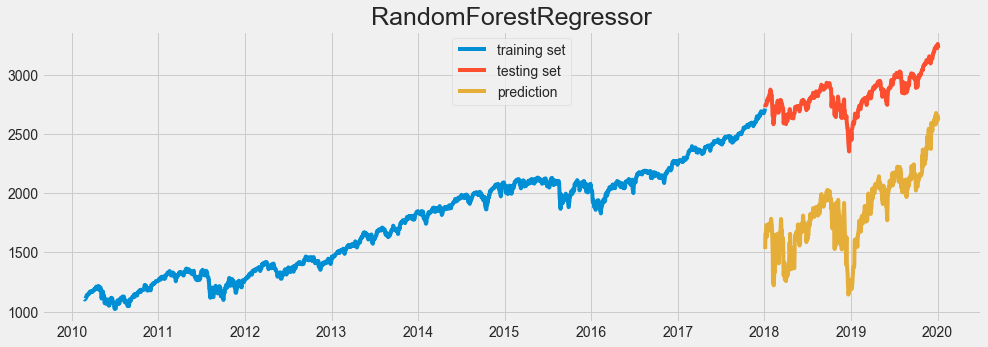

In [76]:
plt.figure(figsize = (15,5))
plt.plot(train['Adj Close'],label = 'training set')
plt.plot(valid[['Adj Close']], label = 'testing set')
plt.plot(preds, label = 'prediction')
plt.legend(loc = 'upper center')
plt.title('RandomForestRegressor', size = 25)

# MODEL3: SARIMA

In [138]:
from pmdarima.arima import auto_arima

In [139]:
p = d = q = range(0, 2)
# Define the p, d and q parameters to take any value between 0 and 2
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [140]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(training,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

In [141]:
train = df[:1987]
valid = df[1987:]
training = train['Adj Close']
validation = valid['Adj Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=8, max_q=8, m=12,start_P=0, seasonal=True,d=1, 
                   D=1, trace=True,error_action='ignore',stepwise= True, suppress_warnings=True)
model.fit(training)
#forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=16245.301, BIC=16273.240, Fit time=7.762 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=17544.226, BIC=17555.402, Fit time=0.113 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=16914.663, BIC=16937.014, Fit time=1.729 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=16245.479, BIC=16267.830, Fit time=1.917 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=17542.231, BIC=17547.819, Fit time=0.064 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=17543.446, BIC=17565.797, Fit time=1.054 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=16247.594, BIC=16281.121, Fit time=5.545 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting sco

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [144]:
forecast = model.predict(n_periods=495)

forecast = pd.DataFrame(forecast,index = validation.index,columns=['Prediction'])

In [145]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1987
Model:             SARIMAX(2, 1, 2)x(0, 1, 1, 12)   Log Likelihood               -8113.971
Date:                            Wed, 22 Jan 2020   AIC                          16241.942
Time:                                    15:37:21   BIC                          16281.057
Sample:                                         0   HQIC                         16256.314
                                           - 1987                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      0.978      0.328      -0.001       0.004
ar.L1         -0.0071      0.101     -0.070      0.944      -0.204       0.190
ar.L2          0.8226      0.082      9.978      0.000       0.661       0.984
ma.L1         -0.0380      0.103     -0.369      0.712      -0.240       0.164
ma.L2         -0.8335      0.087     -9.553      0.000      -1.005      -0.663
ma.S.L12      -0.9946      0.015    -67.855      0.000      -1.023      -0.966
sigma2       211.7332      5.077     41.706      0.000     201.783     221.684
===================================================================================
Ljung-Box (Q):                       66.43   Jarque-Bera (JB):               813.10
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

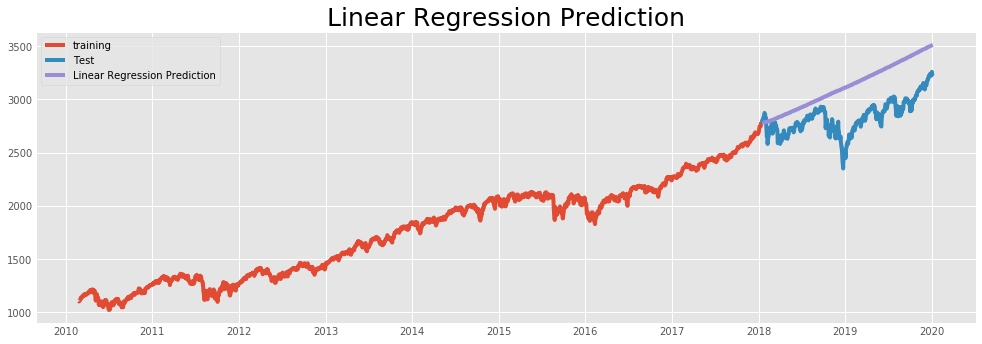

In [150]:
plt.figure(figsize = (15,5))
plt.plot(training,label = 'training')
plt.plot(validation, label = 'Test')
plt.plot(forecast, label = 'Linear Regression Prediction')
plt.title('Linear Regression Prediction', size = 25)
plt.legend()
plt.show()


In [572]:
rms=np.sqrt(np.mean(np.power((np.array(validation)-np.array(forecast)),2)))
rms

263.94366431602094

# CORRELATION HEATMAP

In [25]:

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

Using TensorFlow backend.


In [109]:
import plotly.figure_factory as ff


In [113]:
corrs

Open      High       Low     Close  Adj Close  \
Open                 1.000000  0.999868  0.999787  0.999648   0.999648   
High                 0.999868  1.000000  0.999750  0.999817   0.999817   
Low                  0.999787  0.999750  1.000000  0.999854   0.999854   
Close                0.999648  0.999817  0.999854  1.000000   1.000000   
Adj Close            0.999648  0.999817  0.999854  1.000000   1.000000   
Volume              -0.264799 -0.261717 -0.271614 -0.267456  -0.267456   
polarityaverage      0.194906  0.195150  0.195067  0.194993   0.194993   
subjectivityavg      0.462047  0.462289  0.461900  0.462114   0.462114   
ma1                  0.030640  0.028700  0.034700  0.031453   0.031453   
ma2                 -0.000796 -0.000124  0.000515  0.000095   0.000095   
ma3                 -0.000202  0.000493  0.000512  0.000557   0.000557   
pricehighlowpercent -0.129969 -0.132178 -0.145900 -0.150037  -0.150037   
pricechangepercent  -0.030778 -0.019650 -0.016010 -0.005673  -0.005673   
vol_increment        0.016514  0.017093  0.013785  0.014907   0.014907   
Open1                0.999606  0.999528  0.999279  0.999232   0.999232   
Open_increment       0.030640  0.028700  0.034700  0.031453   0.031453   
RSI                  0.089136  0.086575  0.097311  0.094855   0.094855   
MACD                 0.180203  0.174573  0.186719  0.181163   0.181163   
MACD_signal          0.186301  0.181178  0.190897  0.185846   0.185846   

                       Volume  polarityaverage  subjectivityavg       ma1  \
Open                -0.264799         0.194906         0.462047  0.030640   
High                -0.261717         0.195150         0.462289  0.028700   
Low                 -0.271614         0.195067         0.461900  0.034700   
Close               -0.267456         0.194993         0.462114  0.031453   
Adj Close           -0.267456         0.194993         0.462114  0.031453   
Volume               1.000000        -0.030139        -0.128398 -0.104326   
polarityaverage     -0.030139         1.000000         0.271089  0.046467   
subjectivityavg     -0.128398         0.271089         1.000000 -0.003780   
ma1                 -0.104326         0.046467        -0.003780  1.000000   
ma2                 -0.013066         0.048284         0.012043  0.700917   
ma3                  0.000986         0.039335         0.028819  0.395728   
pricehighlowpercent  0.352435        -0.010195        -0.060989 -0.132592   
pricechangepercent  -0.092026        -0.000910        -0.006359  0.016584   
vol_increment        0.392916        -0.044248        -0.012638  0.003439   
Open1               -0.261994         0.193692         0.462369  0.002585   
Open_increment      -0.104326         0.046467        -0.003780  1.000000   
RSI                 -0.158939         0.050148        -0.005799  0.228994   
MACD                -0.233449         0.046488         0.019066  0.087248   
MACD_signal         -0.208663         0.040801         0.023211 -0.008444   

                          ma2       ma3  pricehighlowpercent  \
Open                -0.000796 -0.000202            -0.129969   
High                -0.000124  0.000493            -0.132178   
Low                  0.000515  0.000512            -0.145900   
Close                0.000095  0.000557            -0.150037   
Adj Close            0.000095  0.000557            -0.150037   
Volume              -0.013066  0.000986             0.352435   
polarityaverage      0.048284  0.039335            -0.010195   
subjectivityavg      0.012043  0.028819            -0.060989   
ma1                  0.700917  0.395728            -0.132592   
ma2                  1.000000  0.862247            -0.001352   
ma3                  0.862247  1.000000             0.011180   
pricehighlowpercent -0.001352  0.011180             1.000000   
pricechangepercent   0.013154  0.001907            -0.777636   
vol_increment       -0.009262 -0.004679             0.106975   
Open1               -0.020471 -0.011310    

In [114]:
corrs = df.corr()

figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    colorscale='Earth',
    annotation_text=corrs.round(2).values,
    showscale=True, reversescale=True)

figure.layout.height = 800
figure.layout.width = 1000

iplot(figure)

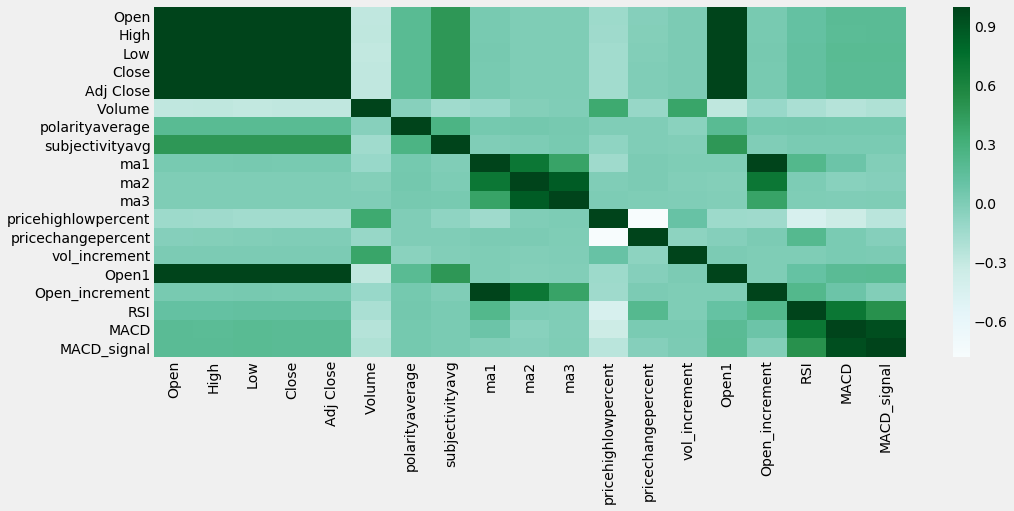

In [26]:
sns.heatmap(df.corr(),cmap = 'BuGn')

# Vector auto regression model

In [77]:
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR


In [78]:
from statsmodels.tsa.stattools import adfuller   #Dickey-Fuller test

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [587]:
nobs = 985
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(1528, 9)
(985, 9)


In [588]:
df_differenced = df_train.diff().dropna()

In [597]:
df.corr()

Open      High       Low     Close  Adj Close    Volume  \
Open             1.000000  0.999871  0.999791  0.999655   0.999655 -0.279741   
High             0.999871  1.000000  0.999756  0.999821   0.999821 -0.276792   
Low              0.999791  0.999756  1.000000  0.999857   0.999857 -0.286516   
Close            0.999655  0.999821  0.999857  1.000000   1.000000 -0.282494   
Adj Close        0.999655  0.999821  0.999857  1.000000   1.000000 -0.282494   
Volume          -0.279741 -0.276792 -0.286516 -0.282494  -0.282494  1.000000   
polarityaverage  0.190238  0.190479  0.190379  0.190299   0.190299 -0.028200   
subjectivityavg  0.473721  0.473981  0.473614  0.473832   0.473832 -0.143935   
RSI              0.120416  0.118048  0.128292  0.126010   0.126010 -0.186575   

                 polarityaverage  subjectivityavg       RSI  
Open                    0.190238         0.473721  0.120416  
High                    0.190479         0.473981  0.118048  
Low                     0.190379         0.473614  0.128292  
Close                   0.190299         0.473832  0.126010  
Adj Close               0.190299         0.473832  0.126010  
Volume                 -0.028200        -0.143935 -0.186575  
polarityaverage         1.000000         0.266157  0.050573  
subjectivityavg         0.266157         1.000000  0.025211  
RSI                     0.050573         0.025211  1.000000

In [50]:
#model_fitted = model.fit(4)
#model_fitted.summary()

In [51]:
#x = model.select_order(maxlags=12)
#x.summary()

# AUTOCORRELATION

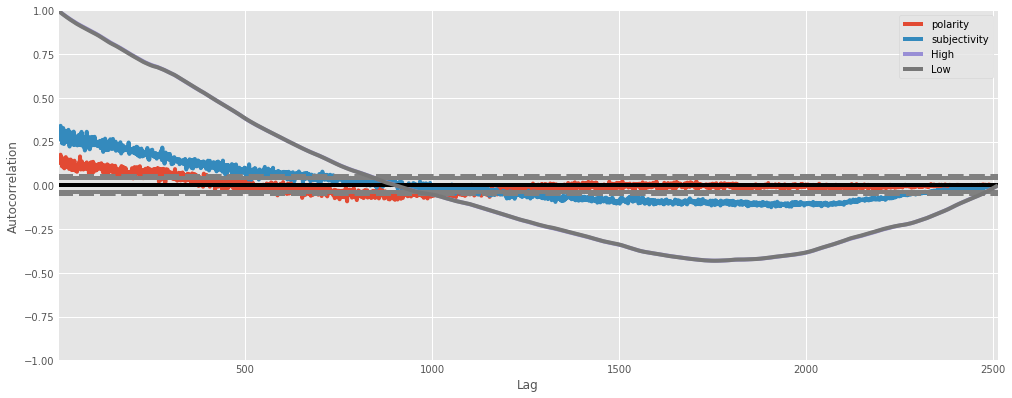

In [596]:
pd.plotting.autocorrelation_plot(df.polarityaverage, label = 'polarity')
pd.plotting.autocorrelation_plot(df.subjectivityavg, label = 'subjectivity')

pd.plotting.autocorrelation_plot(df.High, label = 'High')
pd.plotting.autocorrelation_plot(df.Low, label = 'Low')

# GrangerCausuality Test

In [60]:
#df.drop('Date',axis =1,inplace = True)
df.dropna(inplace = True)

In [61]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-02-24  1095.890015  1106.420044  1095.500000  1105.239990  1105.239990   
2010-02-25  1101.239990  1103.500000  1086.020020  1102.939941  1102.939941   
2010-02-26  1103.099976  1107.239990  1097.560059  1104.489990  1104.489990   
2010-03-01  1105.359985  1116.109985  1105.359985  1115.709961  1115.709961   
2010-03-02  1117.010010  1123.459961  1116.510010  1118.310059  1118.310059   
...                 ...          ...          ...          ...          ...   
2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039  3221.290039   
2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029  3230.780029   
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   

                Volume  polarityaverage  subjectivityavg        ma1  \
Date                                                                  
2010-02-24  4168360000         0.033336         0.125832 -11.599976   
2010-02-25  4521130000         0.010280         0.085276   5.349976   
2010-02-26  3945190000         0.019502         0.104163   1.859985   
2010-03-01  3847640000         0.026185         0.154323   2.260010   
2010-03-02  4134680000         0.022779         0.110208  11.650024   
...                ...              ...              ...        ...   
2019-12-30  3013290000         0.031097         0.136687  -7.139893   
2019-12-31  2893810000         0.051078         0.187795 -24.910156   
2020-01-02  3458250000         0.035426         0.148915  29.489990   
2020-01-03  3461290000         0.018826         0.172826 -18.309814   
2020-01-06  3674070000         0.073101         0.209759  -8.810059   

                  ma2         ma3  pricehighlowpercent  pricechangepercent  \
Date                                                                         
2010-02-24  -9.089966   -2.069946             0.106769            0.853186   
2010-02-25  16.949951   26.039917             0.050779            0.154367   
2010-02-26  -3.489990  -20.439941             0.248984            0.126010   
2010-03-01   0.400024    3.890015             0.035854            0.936344   
2010-03-02   9.390015    8.989990             0.460508            0.116386   
...               ...         ...                  ...                 ...   
2019-12-30 -27.169922  -45.449951             0.609380           -0.580232   
2019-12-31 -17.770264    9.399658             0.029093            0.485201   
2020-01-02  54.400146   72.170410             0.008895            0.406210   
2020-01-03 -47.799805 -102.199951             0.349315            0.263145   
2020-01-06   9.499756   57.299561             0.017252            0.892915   

            vol_increment        Open1  Open_increment        RSI       MACD  \
Date                                                                           
2010-02-24      -0.084611  1107.489990      -11.599976  52.947260  -0.079512   
2010-02-25       0.078027  1095.890015        5.349976  69.303062   0.464488   
2010-02-26      -0.145985  1101.239990        1.859985  68.841006   1.001232   
2010-03-01      -0.025353  1103.099976        2.260010  78.512659   2.257106   
2010-03-02       0.069423  1105.359985       11.650024  75.908014   3.411070   
...                   ...          ...             ...        ...        ...   
2019-12-30       0.194014  3247.229980       -7.139893  81.913308  35.628157   
2019-12-31      -0.041288  3240.090088      -24.910156  85.158034  34.957304   
2020-01-02       0.163215  3215.179932       29.489990  86.848355  36.192769   
2020-01-03       0.000878  3244.669922      -18.309814  71.553009  34.913514   
2020-01-06       0.057914  3226.360107       -8.810059  73.484411  34.425164   

           

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
print(grangercausalitytests(t[['Open','Low']], maxlag=15, addconst=True, verbose=True))
print(grangercausalitytests(t[['High','Low']], maxlag=15, addconst=True, verbose=True))


In [205]:
model = VAR(endog=df)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)


/Users/zoe/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



array([[ 5.60058594e-01,  3.27001953e+00, -2.63000488e+00, ...,
         3.51075263e-03,  1.78618520e-02, -1.39237894e-02],
       [ 4.25000000e+00,  2.93005371e+00,  4.90002441e+00, ...,
        -8.59461560e-04, -1.28310380e-03, -6.00237033e-03],
       [ 5.43994141e+00,  4.34997559e+00,  5.80004883e+00, ...,
        -3.02036215e-03, -1.43600303e-02, -3.75722496e-02],
       ...,
       [ 3.43000488e+01, -2.96997070e+00,  5.67993164e+00, ...,
        -1.85074352e-02,  7.10222136e-03, -3.41116441e-02],
       [-2.34399414e+01, -2.81699219e+01, -2.70100098e+01, ...,
        -4.33593741e-03, -1.36729309e-01,  1.04907091e-01],
       [-2.63500977e+01,  3.57299805e+01,  3.91015625e+00, ...,
         2.42124612e-02,  1.07676905e-01,  1.02414451e-03]])

# FACEBOOK PROPHET

In [6]:
from fbprophet import Prophet


In [17]:
m = Prophet(yearly_seasonality = True)

# Drop the columns
ph_df = df.drop(['Open', 'High', 'Low','Volume'], axis=1)
ph_df.reset_index(inplace= True)
ph_df.rename(columns={'Date': 'ds', 'Close': 'y',}, inplace=True)

ph_df.dropna(inplace =True)

In [20]:
ph_df.drop('Adj Close',axis =1,inplace =True)

In [22]:
prophet_basic = Prophet()
prophet_basic.fit(ph_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [29]:
future= prophet_basic.make_future_dataframe(periods=526)
future.tail(2)

ds
3042 2021-06-14
3043 2021-06-15

In [30]:
forecast=prophet_basic.predict(future)


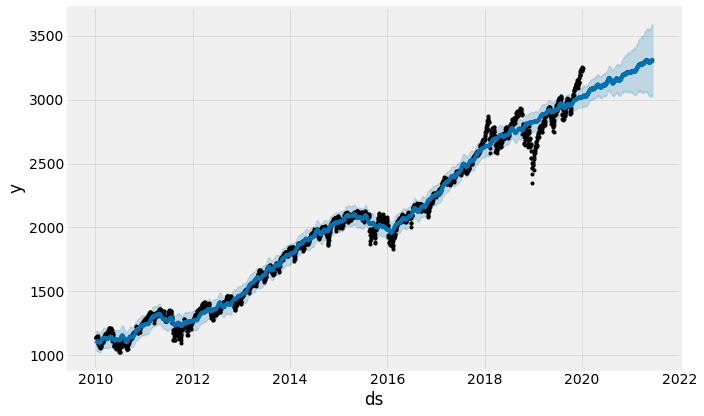

In [31]:
fig1 =prophet_basic.plot(forecast)


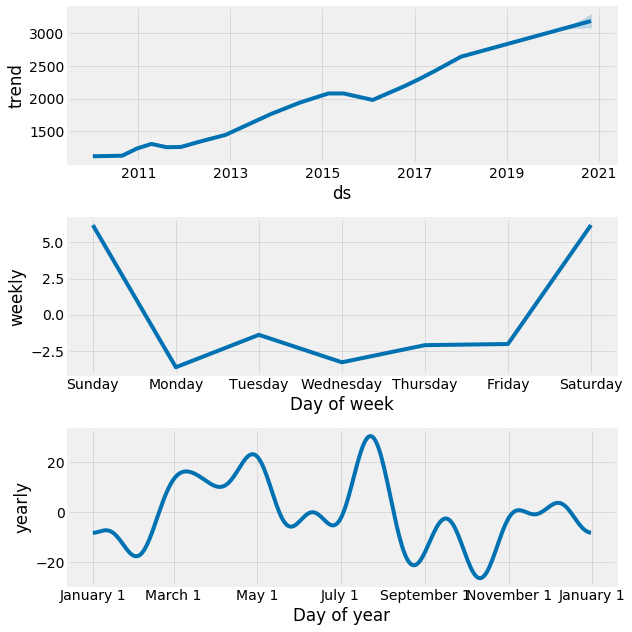

In [28]:
fig1 = prophet_basic.plot_components(forecast)


In [32]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-05  1132.660034  1136.630005  1129.660034  1136.520020  1136.520020   
2010-01-06  1135.709961  1139.189941  1133.949951  1137.140015  1137.140015   
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941   
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980   
2010-01-11  1145.959961  1149.739990  1142.020020  1146.979980  1146.979980   
...                 ...          ...          ...          ...          ...   
2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039  3221.290039   
2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029  3230.780029   
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   

                Volume  
Date                    
2010-01-05  2491020000  
2010-01-06  4972660000  
2010-01-07  5270680000  
2010-01-08  4389590000  
2010-01-11  4255780000  
...                ...  
2019-12-30  3013290000  
2019-12-31  2893810000  
2020-01-02  3458250000  
2020-01-03  3461290000  
2020-01-06  3674070000  

[2518 rows x 6 columns]

In [64]:
df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-02-24  1095.890015  1106.420044  1095.500000  1105.239990  1105.239990   
2010-02-25  1101.239990  1103.500000  1086.020020  1102.939941  1102.939941   
2010-02-26  1103.099976  1107.239990  1097.560059  1104.489990  1104.489990   
2010-03-01  1105.359985  1116.109985  1105.359985  1115.709961  1115.709961   
2010-03-02  1117.010010  1123.459961  1116.510010  1118.310059  1118.310059   
...                 ...          ...          ...          ...          ...   
2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039  3221.290039   
2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029  3230.780029   
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   

                Volume  polarityaverage  subjectivityavg        ma1  \
Date                                                                  
2010-02-24  4168360000         0.033336         0.125832 -11.599976   
2010-02-25  4521130000         0.010280         0.085276   5.349976   
2010-02-26  3945190000         0.019502         0.104163   1.859985   
2010-03-01  3847640000         0.026185         0.154323   2.260010   
2010-03-02  4134680000         0.022779         0.110208  11.650024   
...                ...              ...              ...        ...   
2019-12-30  3013290000         0.031097         0.136687  -7.139893   
2019-12-31  2893810000         0.051078         0.187795 -24.910156   
2020-01-02  3458250000         0.035426         0.148915  29.489990   
2020-01-03  3461290000         0.018826         0.172826 -18.309814   
2020-01-06  3674070000         0.073101         0.209759  -8.810059   

                  ma2         ma3  pricehighlowpercent  pricechangepercent  \
Date                                                                         
2010-02-24  -9.089966   -2.069946             0.106769            0.853186   
2010-02-25  16.949951   26.039917             0.050779            0.154367   
2010-02-26  -3.489990  -20.439941             0.248984            0.126010   
2010-03-01   0.400024    3.890015             0.035854            0.936344   
2010-03-02   9.390015    8.989990             0.460508            0.116386   
...               ...         ...                  ...                 ...   
2019-12-30 -27.169922  -45.449951             0.609380           -0.580232   
2019-12-31 -17.770264    9.399658             0.029093            0.485201   
2020-01-02  54.400146   72.170410             0.008895            0.406210   
2020-01-03 -47.799805 -102.199951             0.349315            0.263145   
2020-01-06   9.499756   57.299561             0.017252            0.892915   

            vol_increment        Open1  Open_increment        RSI       MACD  \
Date                                                                           
2010-02-24      -0.084611  1107.489990      -11.599976  52.947260  -0.079512   
2010-02-25       0.078027  1095.890015        5.349976  69.303062   0.464488   
2010-02-26      -0.145985  1101.239990        1.859985  68.841006   1.001232   
2010-03-01      -0.025353  1103.099976        2.260010  78.512659   2.257106   
2010-03-02       0.069423  1105.359985       11.650024  75.908014   3.411070   
...                   ...          ...             ...        ...        ...   
2019-12-30       0.194014  3247.229980       -7.139893  81.913308  35.628157   
2019-12-31      -0.041288  3240.090088      -24.910156  85.158034  34.957304   
2020-01-02       0.163215  3215.179932       29.489990  86.848355  36.192769   
2020-01-03       0.000878  3244.669922      -18.309814  71.553009  34.913514   
2020-01-06       0.057914  3226.360107       -8.810059  73.484411  34.425164   

           

# LSTM -  LSTM - LSTM - LSTM

In [71]:
import math
from sklearn.preprocessing import MinMaxScaler


In [69]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])

#Converting the dataframe to a numpy array
dataset = data.values

#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 


In [72]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [73]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [364]:
input_data

array([[ 1.13570996e+03,  1.13918994e+03,  1.13394995e+03, ...,
        -9.99900000e+03, -9.99900000e+03, -9.99900000e+03],
       [ 1.13627002e+03,  1.14245996e+03,  1.13131995e+03, ...,
         5.65429888e-02,  1.13570996e+03,  5.60058594e-01],
       [ 1.14052002e+03,  1.14539001e+03,  1.13621997e+03, ...,
        -2.00722619e-01,  1.13627002e+03,  4.25000000e+00],
       ...,
       [ 3.24466992e+03,  3.25813989e+03,  3.23553003e+03, ...,
         1.63215499e-01,  3.21517993e+03,  2.94899902e+01],
       [ 3.22636011e+03,  3.24614990e+03,  3.22234009e+03, ...,
         8.78285264e-04,  3.24466992e+03, -1.83098145e+01],
       [ 3.21755005e+03,  3.24684009e+03,  3.21463989e+03, ...,
         5.79139755e-02,  3.22636011e+03, -8.81005859e+00]])

In [74]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [77]:
from keras import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [75]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [371]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],12)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            5160      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 19,831
Trainable params: 19,831
Non-trainable params: 0
_________________________________________________________________


In [78]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [80]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [99]:
#Train the model
model.fit(x_train, y_train, batch_size=32, epochs=15)

Epoch 1/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.4962e-04
Epoch 2/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.3203e-04
Epoch 3/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.3542e-04
Epoch 4/15
1926/1926 [==============================] - 3s 2ms/step - loss: 1.2842e-04
Epoch 5/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.2809e-04
Epoch 6/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.2756e-04
Epoch 7/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.2574e-04
Epoch 8/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.2393e-04
Epoch 9/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.1858e-04
Epoch 10/15
1926/1926 [==============================] - 3s 1ms/step - loss: 1.1836e-04
Epoch 11/15
1926/1926 [==============================] - 3s 2ms/step - loss: 1.1764e-04
Epoch 12/15
1926/1926 [==================

In [100]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [101]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)


In [102]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [103]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [104]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

41.453202498109476

In [105]:
plt.style.use("ggplot")

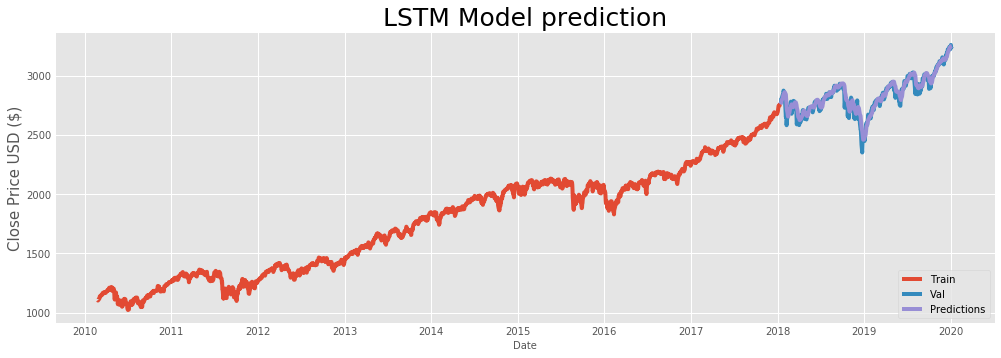

In [106]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(15,5))
plt.title('LSTM Model prediction', size = 25)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# PROPHET PROPHET PROPHET PROPHET 

In [100]:
y = data[['Adj Close']]

In [397]:
data

Open         High          Low        Close    Adj Close  \
Date                                                                          
2010-01-07  1136.270020  1142.459961  1131.319946  1141.689941  1141.689941   
2010-01-08  1140.520020  1145.390015  1136.219971  1144.979980  1144.979980   
2010-01-11  1145.959961  1149.739990  1142.020020  1146.979980  1146.979980   
2010-01-12  1143.810059  1143.810059  1131.770020  1136.219971  1136.219971   
2010-01-13  1137.310059  1148.400024  1133.180054  1145.680054  1145.680054   
...                 ...          ...          ...          ...          ...   
2019-12-30  3240.090088  3240.919922  3216.570068  3221.290039  3221.290039   
2019-12-31  3215.179932  3231.719971  3212.030029  3230.780029  3230.780029   
2020-01-02  3244.669922  3258.139893  3235.530029  3257.850098  3257.850098   
2020-01-03  3226.360107  3246.149902  3222.340088  3234.850098  3234.850098   
2020-01-06  3217.550049  3246.840088  3214.639893  3246.280029  3246.280029   

                Volume  polarityaverage  subjectivityavg  volume_pctchangep  
Date                                                                         
2010-01-07  5270680000         0.003354         0.118907           5.993171  
2010-01-08  4389590000         0.005087         0.141465          16.716818  
2010-01-11  4255780000         0.003285         0.081316           3.048348  
2010-01-12  4716160000         0.024642         0.121703          10.817758  
2010-01-13  4170360000         0.024532         0.128935          11.572975  
...                ...              ...              ...                ...  
2019-12-30  3013290000         0.031097         0.136687          24.071611  
2019-12-31  2893810000         0.051078         0.187795           3.965101  
2020-01-02  3458250000         0.035426         0.148915          19.505082  
2020-01-03  3461290000         0.018826         0.172826           0.087906  
2020-01-06  3674070000         0.073101         0.209759           6.147419  

[2514 rows x 9 columns]

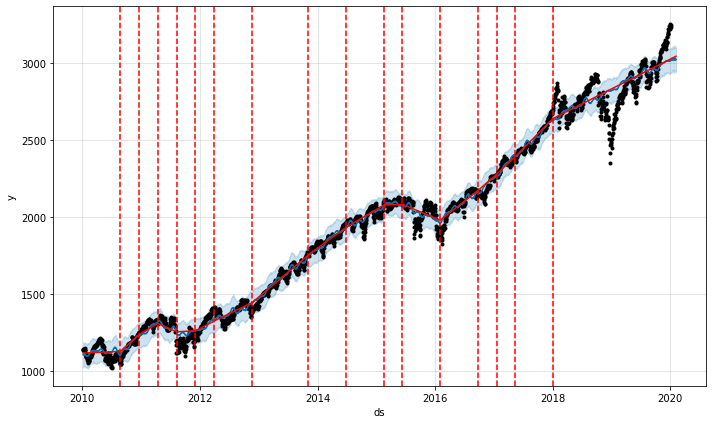

In [120]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


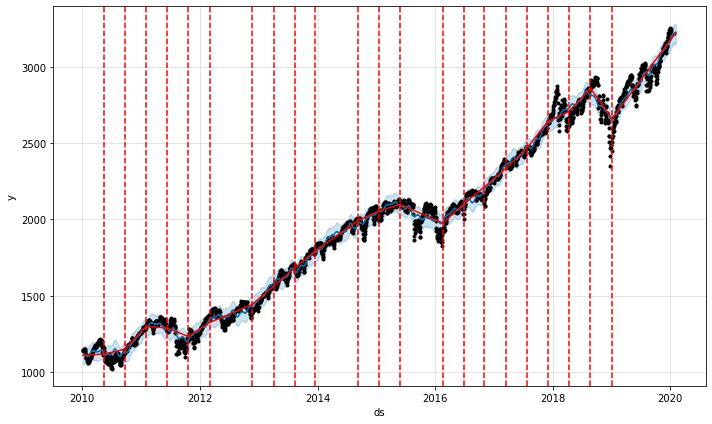

In [121]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


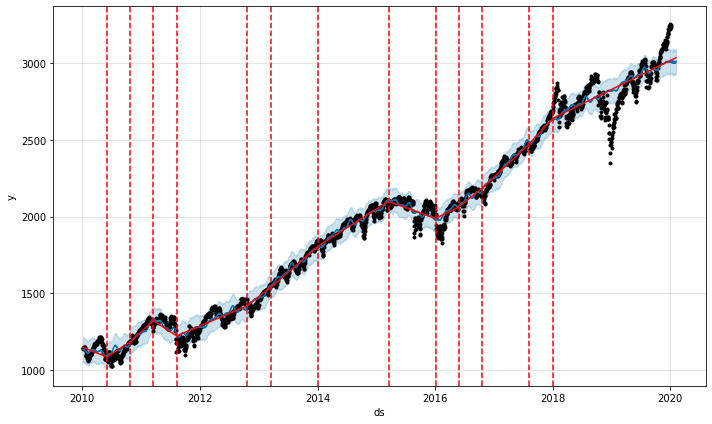

In [122]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# change the prior scale to 0.001  to make the trend less flexible

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


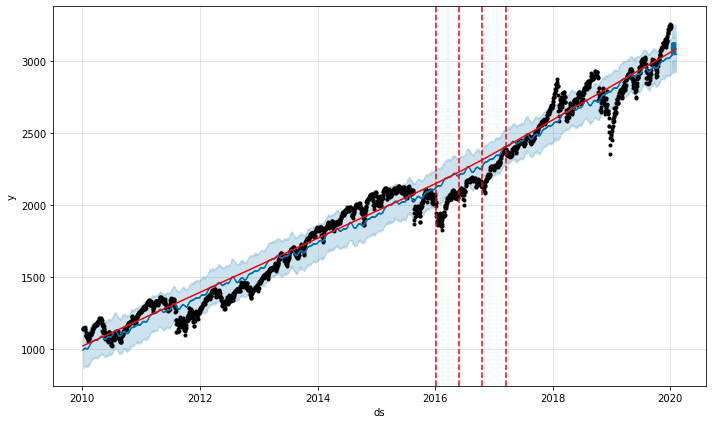

In [123]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [125]:
input_features

Date         Open         High          Low      Volume  \
0    2010-01-06  1135.709961  1139.189941  1133.949951  4972660000   
1    2010-01-07  1136.270020  1142.459961  1131.319946  5270680000   
2    2010-01-08  1140.520020  1145.390015  1136.219971  4389590000   
3    2010-01-11  1145.959961  1149.739990  1142.020020  4255780000   
4    2010-01-12  1143.810059  1143.810059  1131.770020  4716160000   
...         ...          ...          ...          ...         ...   
2510 2019-12-30  3240.090088  3240.919922  3216.570068  3013290000   
2511 2019-12-31  3215.179932  3231.719971  3212.030029  2893810000   
2512 2020-01-02  3244.669922  3258.139893  3235.530029  3458250000   
2513 2020-01-03  3226.360107  3246.149902  3222.340088  3461290000   
2514 2020-01-06  3217.550049  3246.840088  3214.639893  3674070000   

      highlowpercent  changepercent          ma1          ma2          ma3  \
0           0.180270       0.125917 -9999.000000 -9999.000000 -9999.000000   
1           0.067446       0.476992 -9999.000000 -9999.000000 -9999.000000   
2           0.035811       0.391046     2.405029 -9999.000000 -9999.000000   
3           0.240633       0.089010     4.844971     2.439941 -9999.000000   
4           0.668012      -0.663579     1.645020    -3.199951    -5.639893   
...              ...            ...          ...          ...          ...   
2510        0.609380      -0.580232     6.445068    -4.444946   -14.760010   
2511        0.029093       0.485201   -16.025024   -22.470093   -18.025146   
2512        0.008895       0.406210     2.289917    18.314941    40.785034   
2513        0.349315       0.263145     5.590088     3.300171   -15.014771   
2514        0.017252       0.892915   -13.559937   -19.150024   -22.450195   

      vol_increment        Open1  Open_increment  
0      -9999.000000 -9999.000000    -9999.000000  
1          0.056543  1135.709961        0.560059  
2         -0.200723  1136.270020        4.250000  
3         -0.031442  1140.520020        5.439941  
4          0.097618  1145.959961       -2.149902  
...             ...          ...             ...  
2510       0.194014  3247.229980       -7.139893  
2511      -0.041288  3240.090088      -24.910156  
2512       0.163215  3215.179932       29.489990  
2513       0.000878  3244.669922      -18.309814  
2514       0.057914  3226.360107       -8.810059  

[2515 rows x 13 columns]

In [126]:
train_dataset['Volume'] = input_features['Volume']
train_dataset['ma1'] = input_features['ma1']
train_dataset['vol_increment'] = input_features['vol_increment']
train_dataset['Open1'] = input_features['Open1']
train_dataset['ma2'] = input_features['ma2']
train_dataset['highlowpercent'] = input_features['highlowpercent']
train_dataset['Open_increment'] = input_features['Open_increment']

In [130]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Volume')
pro_regressor.add_regressor('ma1')
pro_regressor.add_regressor('vol_increment')
pro_regressor.add_regressor('Open1')
pro_regressor.add_regressor('ma2')
pro_regressor.add_regressor('highlowpercent')
pro_regressor.add_regressor('Open_increment')

In [131]:
train_X= train_dataset[:800]
test_X= train_dataset[800:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zoe/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



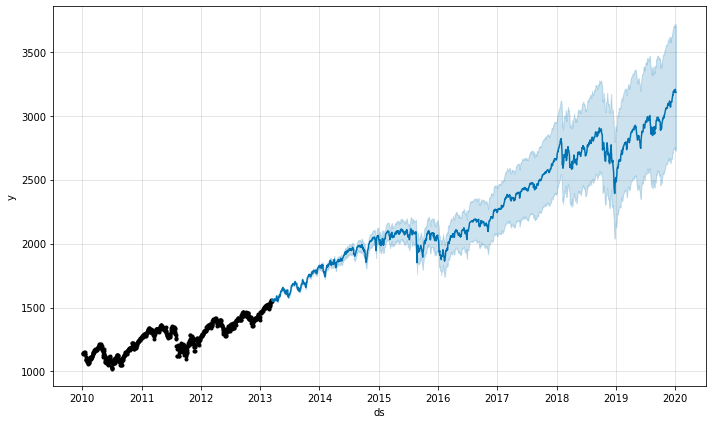

In [132]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [138]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_X["y"], forecast_data["yhat"]))

In [139]:
rms

18.486912935344943

In [187]:
## CALCULATNG BETA

In [396]:
input_features

Date         Open         High          Low      Volume  \
0    2010-01-06  1135.709961  1139.189941  1133.949951  4972660000   
1    2010-01-07  1136.270020  1142.459961  1131.319946  5270680000   
2    2010-01-08  1140.520020  1145.390015  1136.219971  4389590000   
3    2010-01-11  1145.959961  1149.739990  1142.020020  4255780000   
4    2010-01-12  1143.810059  1143.810059  1131.770020  4716160000   
...         ...          ...          ...          ...         ...   
2510 2019-12-30  3240.090088  3240.919922  3216.570068  3013290000   
2511 2019-12-31  3215.179932  3231.719971  3212.030029  2893810000   
2512 2020-01-02  3244.669922  3258.139893  3235.530029  3458250000   
2513 2020-01-03  3226.360107  3246.149902  3222.340088  3461290000   
2514 2020-01-06  3217.550049  3246.840088  3214.639893  3674070000   

      highlowpercent  changepercent          ma1          ma2          ma3  \
0           0.180270       0.125917 -9999.000000 -9999.000000 -9999.000000   
1           0.067446       0.476992 -9999.000000 -9999.000000 -9999.000000   
2           0.035811       0.391046     2.405029 -9999.000000 -9999.000000   
3           0.240633       0.089010     4.844971     2.439941 -9999.000000   
4           0.668012      -0.663579     1.645020    -3.199951    -5.639893   
...              ...            ...          ...          ...          ...   
2510        0.609380      -0.580232     6.445068    -4.444946   -14.760010   
2511        0.029093       0.485201   -16.025024   -22.470093   -18.025146   
2512        0.008895       0.406210     2.289917    18.314941    40.785034   
2513        0.349315       0.263145     5.590088     3.300171   -15.014771   
2514        0.017252       0.892915   -13.559937   -19.150024   -22.450195   

      vol_increment        Open1  Open_increment  
0      -9999.000000 -9999.000000    -9999.000000  
1          0.056543  1135.709961        0.560059  
2         -0.200723  1136.270020        4.250000  
3         -0.031442  1140.520020        5.439941  
4          0.097618  1145.959961       -2.149902  
...             ...          ...             ...  
2510       0.194014  3247.229980       -7.139893  
2511      -0.041288  3240.090088      -24.910156  
2512       0.163215  3215.179932       29.489990  
2513       0.000878  3244.669922      -18.309814  
2514       0.057914  3226.360107       -8.810059  

[2515 rows x 13 columns]

In [401]:
data.reset_index(inplace = True)

In [404]:
y

2259    2535.610107
2260    2568.110107
2261    2580.000000
2262    2573.510010
2263    2588.110107
           ...     
2506    3240.090088
2507    3215.179932
2508    3244.669922
2509    3226.360107
2510    3217.550049
Name: Open, Length: 252, dtype: float64

In [402]:
input_features = data[['Date','Open','High','Low','Volume','polarityaverage','subjectivityavg']]


In [403]:
train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(input_features["Date"])
train_dataset['y']=y
train_dataset.head(2)

ds   y
0 2010-01-07 NaN
1 2010-01-08 NaN

In [112]:
from fbprophet import Prophet


In [114]:
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zoe/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [116]:
future= prophet_basic.make_future_dataframe(periods=30)
future.tail(2)

ds
2543 2020-02-04
2544 2020-02-05

In [117]:
forecast = prophet_basic.predict(future)


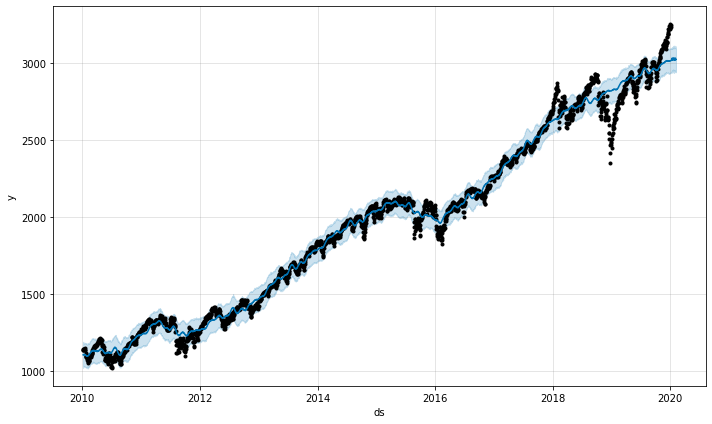

In [118]:
fig1 = prophet_basic.plot(forecast)


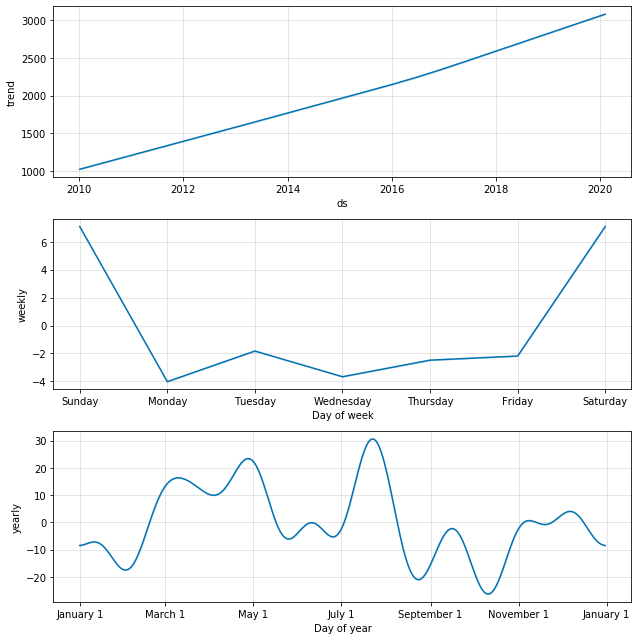

In [185]:
fig1 = prophet_basic.plot_components(forecast)

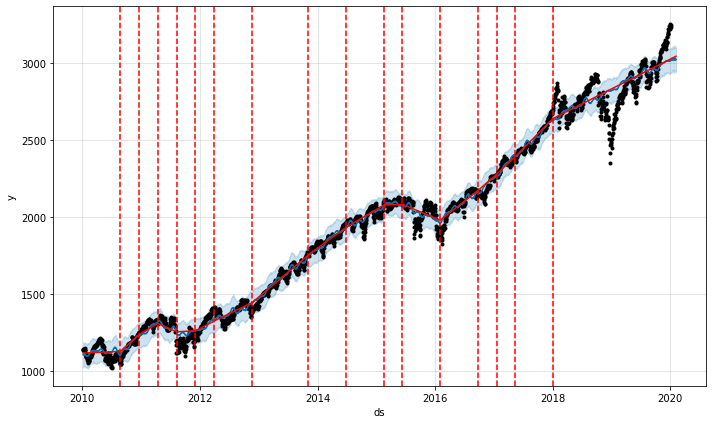

In [120]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


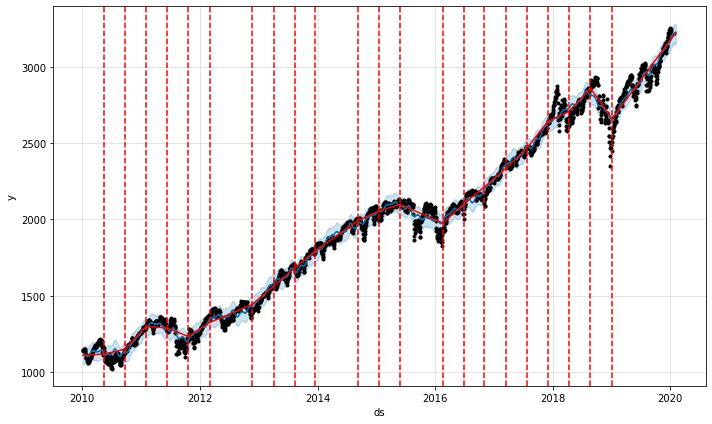

In [121]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


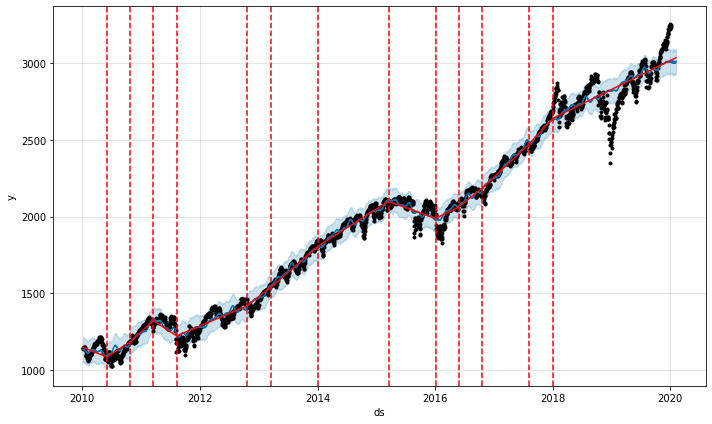

In [122]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

# change the prior scale to 0.001  to make the trend less flexible

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


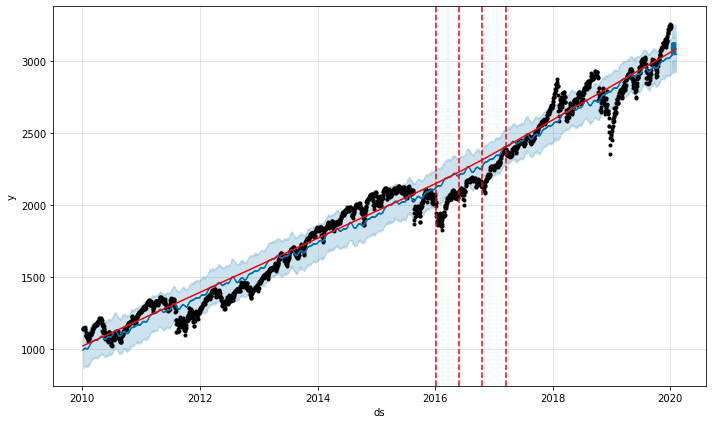

In [123]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [125]:
input_features

Date         Open         High          Low      Volume  \
0    2010-01-06  1135.709961  1139.189941  1133.949951  4972660000   
1    2010-01-07  1136.270020  1142.459961  1131.319946  5270680000   
2    2010-01-08  1140.520020  1145.390015  1136.219971  4389590000   
3    2010-01-11  1145.959961  1149.739990  1142.020020  4255780000   
4    2010-01-12  1143.810059  1143.810059  1131.770020  4716160000   
...         ...          ...          ...          ...         ...   
2510 2019-12-30  3240.090088  3240.919922  3216.570068  3013290000   
2511 2019-12-31  3215.179932  3231.719971  3212.030029  2893810000   
2512 2020-01-02  3244.669922  3258.139893  3235.530029  3458250000   
2513 2020-01-03  3226.360107  3246.149902  3222.340088  3461290000   
2514 2020-01-06  3217.550049  3246.840088  3214.639893  3674070000   

      highlowpercent  changepercent          ma1          ma2          ma3  \
0           0.180270       0.125917 -9999.000000 -9999.000000 -9999.000000   
1           0.067446       0.476992 -9999.000000 -9999.000000 -9999.000000   
2           0.035811       0.391046     2.405029 -9999.000000 -9999.000000   
3           0.240633       0.089010     4.844971     2.439941 -9999.000000   
4           0.668012      -0.663579     1.645020    -3.199951    -5.639893   
...              ...            ...          ...          ...          ...   
2510        0.609380      -0.580232     6.445068    -4.444946   -14.760010   
2511        0.029093       0.485201   -16.025024   -22.470093   -18.025146   
2512        0.008895       0.406210     2.289917    18.314941    40.785034   
2513        0.349315       0.263145     5.590088     3.300171   -15.014771   
2514        0.017252       0.892915   -13.559937   -19.150024   -22.450195   

      vol_increment        Open1  Open_increment  
0      -9999.000000 -9999.000000    -9999.000000  
1          0.056543  1135.709961        0.560059  
2         -0.200723  1136.270020        4.250000  
3         -0.031442  1140.520020        5.439941  
4          0.097618  1145.959961       -2.149902  
...             ...          ...             ...  
2510       0.194014  3247.229980       -7.139893  
2511      -0.041288  3240.090088      -24.910156  
2512       0.163215  3215.179932       29.489990  
2513       0.000878  3244.669922      -18.309814  
2514       0.057914  3226.360107       -8.810059  

[2515 rows x 13 columns]

In [126]:
train_dataset['Volume'] = input_features['Volume']
train_dataset['ma1'] = input_features['ma1']
train_dataset['vol_increment'] = input_features['vol_increment']
train_dataset['Open1'] = input_features['Open1']
train_dataset['ma2'] = input_features['ma2']
train_dataset['highlowpercent'] = input_features['highlowpercent']
train_dataset['Open_increment'] = input_features['Open_increment']

In [130]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Volume')
pro_regressor.add_regressor('ma1')
pro_regressor.add_regressor('vol_increment')
pro_regressor.add_regressor('Open1')
pro_regressor.add_regressor('ma2')
pro_regressor.add_regressor('highlowpercent')
pro_regressor.add_regressor('Open_increment')

In [131]:
train_X= train_dataset[:800]
test_X= train_dataset[800:]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zoe/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



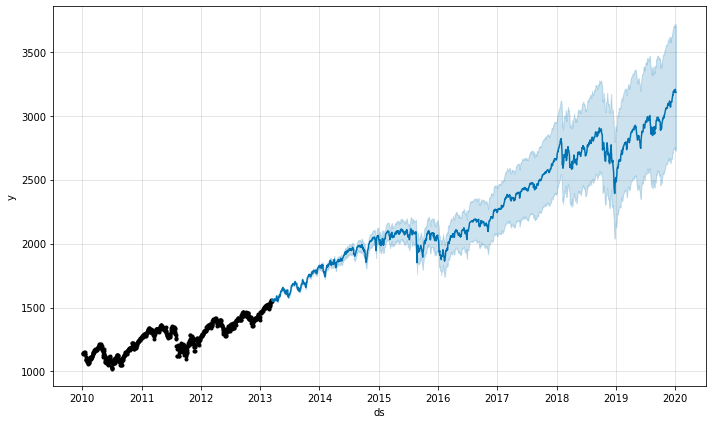

In [132]:
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

In [138]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_X["y"], forecast_data["yhat"]))

In [139]:
rms

18.486912935344943

In [405]:
y = data[['Adj Close']]

In [406]:


input_features = data[['Date','Open','High','Low','Volume','polarityaverage','subjectivityavg']]



train_dataset= pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(input_features["Date"])
train_dataset['y']=y
train_dataset.head(2)



ds            y
0 2010-01-07  1141.689941
1 2010-01-08  1144.979980

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zoe/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


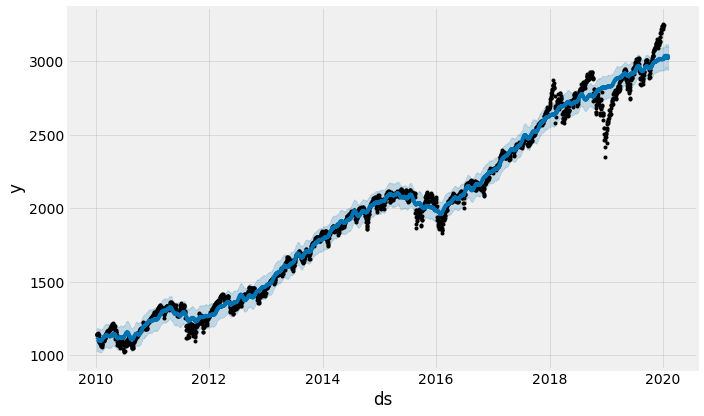

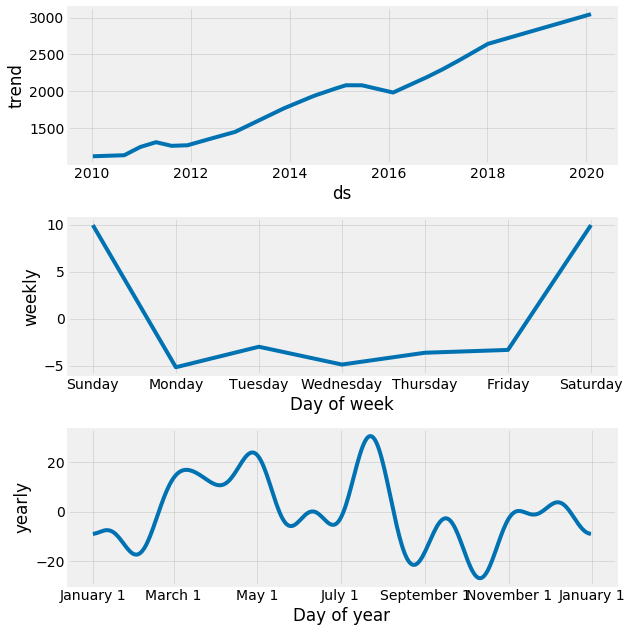

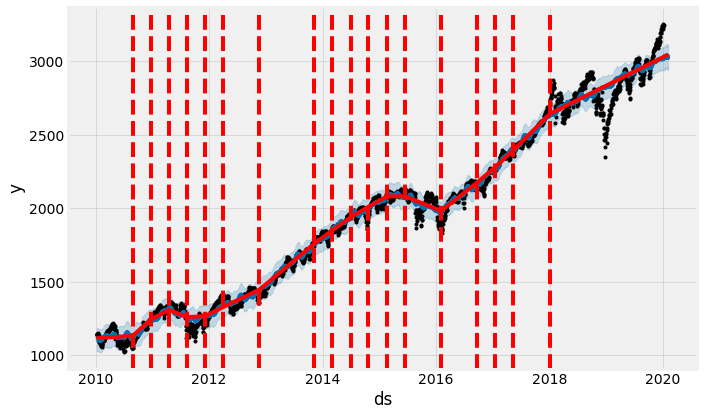

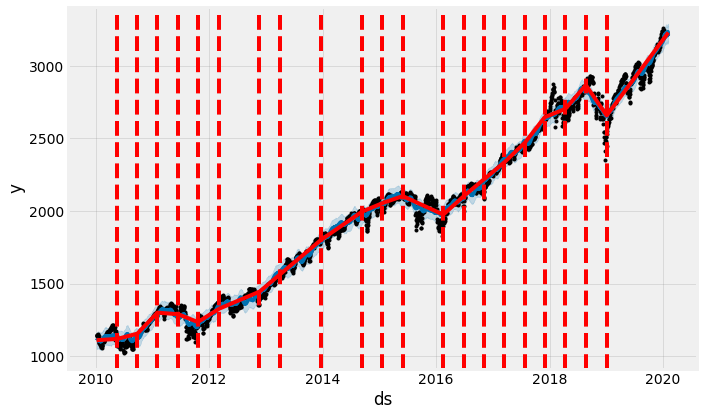

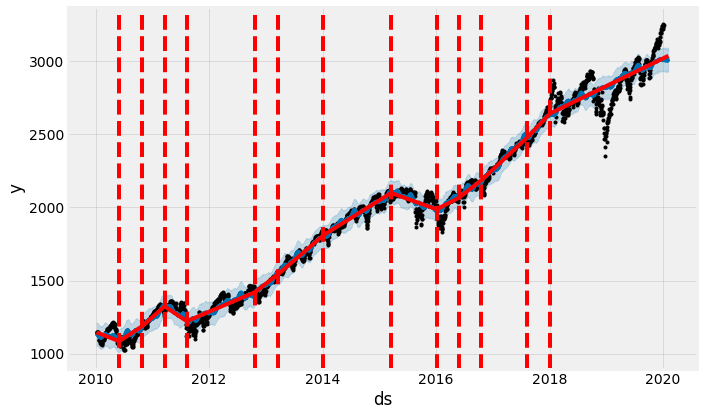

In [407]:
from fbprophet import Prophet


prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

future= prophet_basic.make_future_dataframe(periods=30)
future.tail(2)

forecast = prophet_basic.predict(future)


fig1 = prophet_basic.plot(forecast)


fig1 = prophet_basic.plot_components(forecast)

from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Date         Open         High          Low      Volume  \
0    2010-01-07  1136.270020  1142.459961  1131.319946  5270680000   
1    2010-01-08  1140.520020  1145.390015  1136.219971  4389590000   
2    2010-01-11  1145.959961  1149.739990  1142.020020  4255780000   
3    2010-01-12  1143.810059  1143.810059  1131.770020  4716160000   
4    2010-01-13  1137.310059  1148.400024  1133.180054  4170360000   
...         ...          ...          ...          ...         ...   
2509 2019-12-30  3240.090088  3240.919922  3216.570068  3013290000   
2510 2019-12-31  3215.179932  3231.719971  3212.030029  2893810000   
2511 2020-01-02  3244.669922  3258.139893  3235.530029  3458250000   
2512 2020-01-03  3226.360107  3246.149902  3222.340088  3461290000   
2513 2020-01-06  3217.550049  3246.840088  3214.639893  3674070000   

      polarityaverage  subjectivityavg  
0            0.003354         0.118907  
1            0.005087         0.141465  
2            0.003285         0.081316  
3            0.024642         0.121703  
4            0.024532         0.128935  
...               ...              ...  
2509         0.031097         0.136687  
2510         0.051078         0.187795  
2511         0.035426         0.148915  
2512         0.018826         0.172826  
2513         0.073101         0.209759  

[2514 rows x 7 columns]

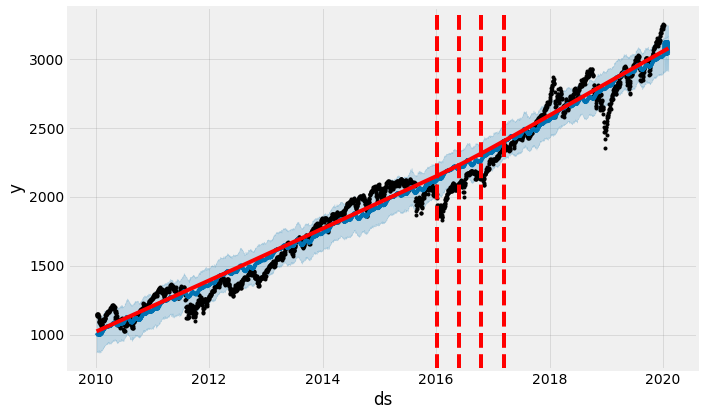

In [408]:
# change the prior scale to 0.001  to make the trend less flexible

pro_change= Prophet(n_changepoints=20, daily_seasonality = True, yearly_seasonality=True, changepoint_prior_scale=0.001)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

input_features



In [409]:
input_features

Date         Open         High          Low      Volume  \
0    2010-01-07  1136.270020  1142.459961  1131.319946  5270680000   
1    2010-01-08  1140.520020  1145.390015  1136.219971  4389590000   
2    2010-01-11  1145.959961  1149.739990  1142.020020  4255780000   
3    2010-01-12  1143.810059  1143.810059  1131.770020  4716160000   
4    2010-01-13  1137.310059  1148.400024  1133.180054  4170360000   
...         ...          ...          ...          ...         ...   
2509 2019-12-30  3240.090088  3240.919922  3216.570068  3013290000   
2510 2019-12-31  3215.179932  3231.719971  3212.030029  2893810000   
2511 2020-01-02  3244.669922  3258.139893  3235.530029  3458250000   
2512 2020-01-03  3226.360107  3246.149902  3222.340088  3461290000   
2513 2020-01-06  3217.550049  3246.840088  3214.639893  3674070000   

      polarityaverage  subjectivityavg  
0            0.003354         0.118907  
1            0.005087         0.141465  
2            0.003285         0.081316  
3            0.024642         0.121703  
4            0.024532         0.128935  
...               ...              ...  
2509         0.031097         0.136687  
2510         0.051078         0.187795  
2511         0.035426         0.148915  
2512         0.018826         0.172826  
2513         0.073101         0.209759  

[2514 rows x 7 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/zoe/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



11.307586771134158

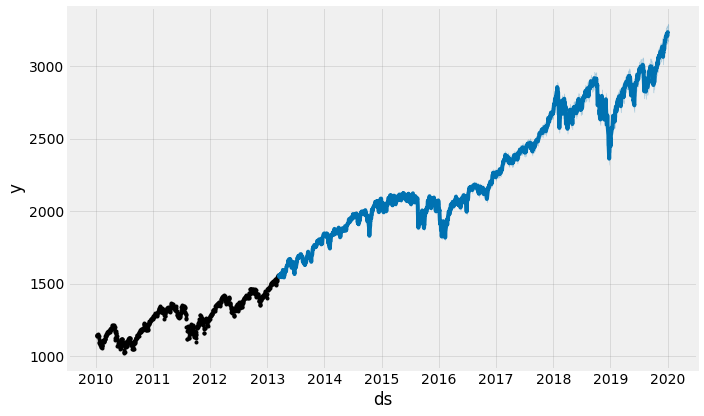

In [411]:


train_dataset['subjectivity'] = input_features['subjectivityavg']
train_dataset['polarity'] = input_features['polarityaverage']
train_dataset['Open'] = input_features['Open']
train_dataset['High'] = input_features['High']
train_dataset['Low'] = input_features['Low']
train_dataset['Volume'] = input_features['Volume']

pro_regressor= Prophet()
pro_regressor.add_regressor('Volume')
pro_regressor.add_regressor('High')
pro_regressor.add_regressor('Low')
pro_regressor.add_regressor('Open')
#pro_regressor.add_regressor('polarity')
#pro_regressor.add_regressor('subjectivity')

train_X= train_dataset[:800]
test_X= train_dataset[800:]

#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);

from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test_X["y"], forecast_data["yhat"]))

rms

In [496]:
forecast_data

ds        trend   yhat_lower   yhat_upper  trend_lower  \
0    2013-03-14  1256.159633  1556.398119  1569.581072  1256.159633   
1    2013-03-15  1256.158136  1552.230091  1564.697226  1256.158136   
2    2013-03-18  1256.153646  1543.201883  1556.273941  1256.153646   
3    2013-03-19  1256.152149  1540.786852  1553.401086  1256.152149   
4    2013-03-20  1256.150653  1554.352185  1566.822422  1256.150653   
...         ...          ...          ...          ...          ...   
1709 2019-12-30  1252.444796  3155.310736  3268.347148  1198.684290   
1710 2019-12-31  1252.443299  3158.924395  3272.687967  1198.680364   
1711 2020-01-02  1252.440306  3181.287802  3294.804431  1198.635531   
1712 2020-01-03  1252.438809  3172.694283  3287.027091  1198.601792   
1713 2020-01-06  1252.434319  3174.144739  3288.200339  1198.500574   

      trend_upper         High   High_lower   High_upper          Low  ...  \
0     1256.159633   246.965497   246.965497   246.965497   210.415173  ...   
1     1256.158136   247.231450   247.231450   247.231450   211.312070  ...   
2     1256.153646   244.643224   244.643224   244.643224   203.511832  ...   
3     1256.152149   241.585308   241.585308   241.585308   198.689015  ...   
4     1256.150653   245.405594   245.405594   245.405594   205.871727  ...   
...           ...          ...          ...          ...          ...  ...   
1709  1312.938604  1733.931812  1733.931812  1733.931812  1432.319412  ...   
1710  1312.987379  1725.777295  1725.777295  1725.777295  1428.981671  ...   
1711  1313.084928  1749.194996  1749.194996  1749.194996  1446.258377  ...   
1712  1313.133703  1738.567485  1738.567485  1738.567485  1436.561409  ...   
1713  1313.275199  1739.179242  1739.179242  1739.179242  1430.900388  ...   

         weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
0     22.671758     22.671758     22.671758  1.387389      1.387389   
1     22.318704     22.318704     22.318704  1.451161      1.451161   
2     22.283542     22.283542     22.283542  1.567950      1.567950   
3     22.194828     22.194828     22.194828  1.578816      1.578816   
4     21.999632     21.999632     21.999632  1.575112      1.575112   
...         ...           ...           ...       ...           ...   
1709  22.283542     22.283542     22.283542  1.802229      1.802229   
1710  22.194828     22.194828     22.194828  2.018655      2.018655   
1711  22.671758     22.671758     22.671758  2.357250      2.357250   
1712  22.318704     22.318704     22.318704  2.474827      2.474827   
1713  22.283542     22.283542     22.283542  2.610671      2.610671   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
0         1.387389                   0.0                         0.0   
1         1.451161                   0.0                         0.0   
2         1.567950                   0.0                         0.0   
3         1.578816                   0.0                         0.0   
4         1.575112                   0.0                         0.0   
...            ...                   ...                         ...   
1709      1.802229                   0.0                         0.0   
1710      2.018655                   0.0                         0.0   
1711      2.357250                   0.0                         0.0   
1712      2.474827                   0.0                         0.0   
1713      2.610671                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
0                            0.0  1562.882210  
1                            0.0  1558.403959  
2                            0.0  1549.536557  
3                            0.0  1547.027443  
4                            0.0  1560.164845  
...                          ...          ...  
1709                         0.0  3207.950319  
1710                         0.0  3212.242706  
1711                         0.0  3235.240668  
1712                     